In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from joblib import dump, load

from tensorflow.keras.datasets import mnist


In [2]:
clear_df = pd.read_pickle("clear_functional.pkl")
# clear_df = pd.read_pickle("clear_functional_emovo.pkl")

# clear_df = pd.read_pickle("pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("pitch_functional_emovo.pkl")

In [3]:
def get_speaker(clear_df, speaker):
    names = clear_df.filename.to_list()

    test = []
    m = 0
    names
    for i in range(len(clear_df)):
        if speaker in names[i]:
            test.append(names[i])
            m +=1

    mask = clear_df['filename'].isin(test)
    test_df = clear_df[mask].reset_index()
    train_df = clear_df[~mask].reset_index()
    return  train_df, test_df

# train_df = clear_df.drop(test_df.index).reset_index()

In [4]:
labels = clear_df["label"].unique()
labels

array(['neutral', 'guilt', 'disgust', 'happiness', 'fear', 'anger',
       'surprise', 'sadness'], dtype=object)

In [6]:
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask]
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df


In [7]:
train_df, test_df = get_speaker(clear_df, "f_01")

In [22]:
train_df, val_df = get_speaker(train_df, "f_36")

In [23]:
val_df

,level_0,index,filename,features,label
0,18,24,f_36_neu00a.wav,F0semitoneFr...,neutral
1,19,25,f_36_neu01b.wav,F0semitoneFr...,neutral
2,20,26,f_36_neu02b.wav,F0semitoneFr...,neutral
3,21,27,f_36_neu03b.wav,F0semitoneFr...,neutral
4,22,28,f_36_neu04b.wav,F0semitoneFr...,neutral
...,...,...,...,...,...
196,8264,8389,PR_f_36_gio94b.wav,F0semitoneFr...,happiness
197,8265,8390,PR_f_36_pau01c.wav,F0semitoneFr...,fear
198,8266,8391,PR_f_36_pau12b.wav,F0semitoneFr...,fear
199,8267,8392,PR_f_36_tri01c.wav,F0semitoneFr...,sadness


In [8]:
train = []

for i,emotion in enumerate(labels):
    train.append(get_emo_df(emotion,train_df))

Processing neutral ...
Processed 326 file for neutral
Processing guilt ...
Processed 1115 file for guilt
Processing disgust ...
Processed 1657 file for disgust
Processing happiness ...
Processed 1379 file for happiness
Processing fear ...
Processed 1141 file for fear
Processing anger ...
Processed 1456 file for anger
Processing surprise ...
Processed 987 file for surprise
Processing sadness ...
Processed 1510 file for sadness


In [9]:
test = []

for i,emotion in enumerate(labels):
    test.append(get_emo_df(emotion,test_df))

Processing neutral ...
Processed 6 file for neutral
Processing guilt ...
Processed 14 file for guilt
Processing disgust ...
Processed 21 file for disgust
Processing happiness ...
Processed 16 file for happiness
Processing fear ...
Processed 15 file for fear
Processing anger ...
Processed 21 file for anger
Processing surprise ...
Processed 13 file for surprise
Processing sadness ...
Processed 19 file for sadness


In [16]:
val = []

for i,emotion in enumerate(labels):
    val.append(get_emo_df(emotion,val_df))

NameError: name 'val_df' is not defined

In [10]:
def split_train_val(data):
    data_classes = (list((data["label"].unique())))
    Y = keras.utils.to_categorical(list((data["label"].apply(data_classes.index))))
    X = pd.concat(data["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())
    X_train, X_val, y_train, y_val = train_test_split(_X, Y, test_size=0.2, random_state=22)
    _X_train = X_train.to_numpy()
    _X_val = X_val.to_numpy()
    
    return _X_train, _X_val, y_train, y_val


def obtain_test(data):
    data_classes = (list((data["label"].unique())))
    Y = keras.utils.to_categorical(list((data["label"].apply(data_classes.index))))
    X = pd.concat(data["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())

    _X_test = _X.to_numpy()
    return _X_test

In [11]:
def build_autoencoder(neurons_in=None):
    
    input_l = Input(shape=(88,),name='input_l')

    encoded_l1 = Dense(64, activation='relu', name='encoded_1')(input_l) 
    encoded_l2 = Dense(32, activation='relu', name='encoded_2')(encoded_l1)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    bottleneck = Dense(16, activation='relu', name='bottleneck')(encoded_l2)

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    decoded_l2 = Dense(32, activation='relu', name='decoded_4')(bottleneck)
    decoded_l3 = Dense(64, activation='relu', name='decoded_5')(decoded_l2)

    output_l = Dense(88, activation='sigmoid', name='output_l')(decoded_l3)

    ac = Model(input_l,output_l)
    
    ac.compile(loss='binary_crossentropy', optimizer='adam')
    
    return ac

In [14]:
from datetime import datetime  
def train_autoencoder(emotion,data_train, data_val):
    name = datetime.now().strftime(f"model/autoencoders_one_out/boxplot/ae_{emotion}_aug_emovo_%d_%m_%Y_%H_%M_%S.keras")
    print(f"training on {emotion}")
    print(f"Model name : {name}")
    ae = build_autoencoder()
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=0,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )
    ]

    _X_train, _X_val, y_train, y_val = split_train_val(data_train)


    _X_train =  obtain_test(data_train)
    # _X_val =  obtain_test(data_val)
    history = ae.fit(_X_train,_X_train,
                validation_data = (_X_val,_X_val),
                epochs=5000,
                batch_size=128,
                verbose=0,
                callbacks = callbacks)
    
    print("last loss: ", history.history['val_loss'][-1])
    return ae

In [17]:
autoencoders = []
val = [0] * 10000
for i,emotion in enumerate(labels):
    autoencoders.append(train_autoencoder(emotion, train[i], val[i]))

training on neutral
Model name : model/autoencoders_one_out/boxplot/ae_neutral_aug_emovo_10_11_2024_17_09_35.keras
last loss:  0.5773071646690369
training on guilt
Model name : model/autoencoders_one_out/boxplot/ae_guilt_aug_emovo_10_11_2024_17_09_52.keras
last loss:  0.5559147596359253
training on disgust
Model name : model/autoencoders_one_out/boxplot/ae_disgust_aug_emovo_10_11_2024_17_10_05.keras
last loss:  0.5495714545249939
training on happiness
Model name : model/autoencoders_one_out/boxplot/ae_happiness_aug_emovo_10_11_2024_17_10_18.keras
last loss:  0.5713486671447754
training on fear
Model name : model/autoencoders_one_out/boxplot/ae_fear_aug_emovo_10_11_2024_17_10_30.keras
last loss:  0.5608652234077454
training on anger
Model name : model/autoencoders_one_out/boxplot/ae_anger_aug_emovo_10_11_2024_17_10_44.keras
last loss:  0.5509685277938843
training on surprise
Model name : model/autoencoders_one_out/boxplot/ae_surprise_aug_emovo_10_11_2024_17_10_55.keras
last loss:  0.568

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = []
y_pred = []
errors = []

for n in tqdm(range(len(train))):
    X_test = obtain_test(train[n])
    print("test ottenuto")
    cls = []
    for i in tqdm(range(len(X_test))):
        _er = []
        for encoder in autoencoders :
            #print(labels[x])
            _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88), verbose = 0).reshape(88,)))
        errors.append(_er)
        y_pred.append(np.argmin(_er))
        y_true.append(n)
    #pred.append(cls)

  0%|          | 0/8 [00:00<?, ?it/s]

test ottenuto


 12%|█▎        | 1/8 [01:34<11:02, 94.64s/it]

test ottenuto


 25%|██▌       | 2/8 [06:55<22:45, 227.66s/it]

test ottenuto


 38%|███▊      | 3/8 [14:48<28:18, 339.74s/it]

test ottenuto


 50%|█████     | 4/8 [21:18<23:58, 359.70s/it]

test ottenuto


 62%|██████▎   | 5/8 [27:39<18:21, 367.17s/it]

test ottenuto


 75%|███████▌  | 6/8 [34:40<12:51, 385.62s/it]

test ottenuto


 88%|████████▊ | 7/8 [39:37<05:56, 356.73s/it]

test ottenuto


100%|██████████| 8/8 [47:11<00:00, 353.90s/it]


In [20]:
test_errors = errors

In [23]:
train_errors = errors

In [24]:
import pickle
with open('errors_train_demos.pkl', 'wb') as handle:
    pickle.dump(train_errors, handle)



with open('errors_test_demos.pkl', 'wb') as handle:
    pickle.dump(test_errors, handle)

In [26]:
import pickle
with open('errors_train_demos.pkl', 'rb') as handle:
    prova_train = pickle.load(handle)



with open('errors_test_demos.pkl', 'rb') as handle:
    prova_test = pickle.load(handle)



prova_train == train_errors, prova_test == test_errors

(True, True)

In [27]:
import pickle
with open('errors_train_demos.pkl', 'rb') as handle:
    train_errors = pickle.load(handle)



with open('errors_test_demos.pkl', 'rb') as handle:
    test_errors = pickle.load(handle)


data_train =np.array(train_errors)
data_test = np.array(test_errors)


In [28]:
emo = []

for i in range(0,data_train.shape[0],70):
    emo.append(data_train[i:i+70])


In [29]:
emo_test = []

for i in range(0,data_test.shape[0],14):
    emo_test.append(data_test[i:i+14])


In [30]:
emo[0][:,0]

array([0.00884276, 0.00822179, 0.00295549, 0.01439629, 0.00664375,
       0.00629719, 0.00985587, 0.00426281, 0.00302997, 0.00687592,
       0.00440858, 0.00469992, 0.00773343, 0.00325961, 0.00401602,
       0.01150695, 0.00725989, 0.00761355, 0.00712722, 0.00820202,
       0.00452104, 0.00560086, 0.0043171 , 0.00819095, 0.00469834,
       0.00693257, 0.00575657, 0.00464633, 0.0069342 , 0.00644785,
       0.0053757 , 0.0038364 , 0.00254492, 0.00413592, 0.00705271,
       0.00859336, 0.01044658, 0.0056851 , 0.00222507, 0.00542017,
       0.00846541, 0.01306677, 0.00325394, 0.00309206, 0.00548965,
       0.00408218, 0.00933453, 0.00703206, 0.00437413, 0.00340292,
       0.00597174, 0.00788191, 0.00975752, 0.00967901, 0.00628392,
       0.00611098, 0.00865279, 0.0165773 , 0.00571653, 0.00656632,
       0.00690023, 0.00523463, 0.00821099, 0.0052163 , 0.00434133,
       0.01640012, 0.00561086, 0.00298062, 0.0046134 , 0.01053026],
      dtype=float32)

In [33]:
from scipy import stats

stats.ttest_ind(emo[0][:,0], emo[0][:,1])
# stats.ttest_ind(emo[0][:,0], emo[0][:,2])
# stats.ttest_ind(emo[0][:,0], emo[0][:,3])
# stats.ttest_ind(emo[0][:,0], emo[0][:,4])
# stats.ttest_ind(emo[0][:,0], emo[0][:,5])
# stats.ttest_ind(emo[0][:,0], emo[0][:,6])


TtestResult(statistic=-42.99539604466775, pvalue=8.483827893352115e-82, df=138.0)

In [31]:
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,1])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,2])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,3])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,4])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,5])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,6])

NameError: name 'stats' is not defined

In [ ]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 7
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(17,17))
# for x in range(n_rows):
for i in range(len(emo)):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)

    axes[i].boxplot([emo[i][:,0], emo[i][:,1],emo[i][:,2],emo[i][:,3],emo[i][:,4],emo[i][:,5],emo[i][:,6]], tick_labels=labels )
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Train")

plt.savefig("OvA_EMOVO_train.png")

In [96]:
data_test.shape

(98, 7)

In [98]:
for i in range(len(emo_test)):
    print(emo_test[i].shape)

(14, 7)
(14, 7)
(14, 7)
(14, 7)
(14, 7)
(14, 7)
(14, 7)


In [105]:
labels

array(['disgust', 'joy', 'neutrality', 'fear', 'anger', 'surprise',
       'sadness'], dtype=object)

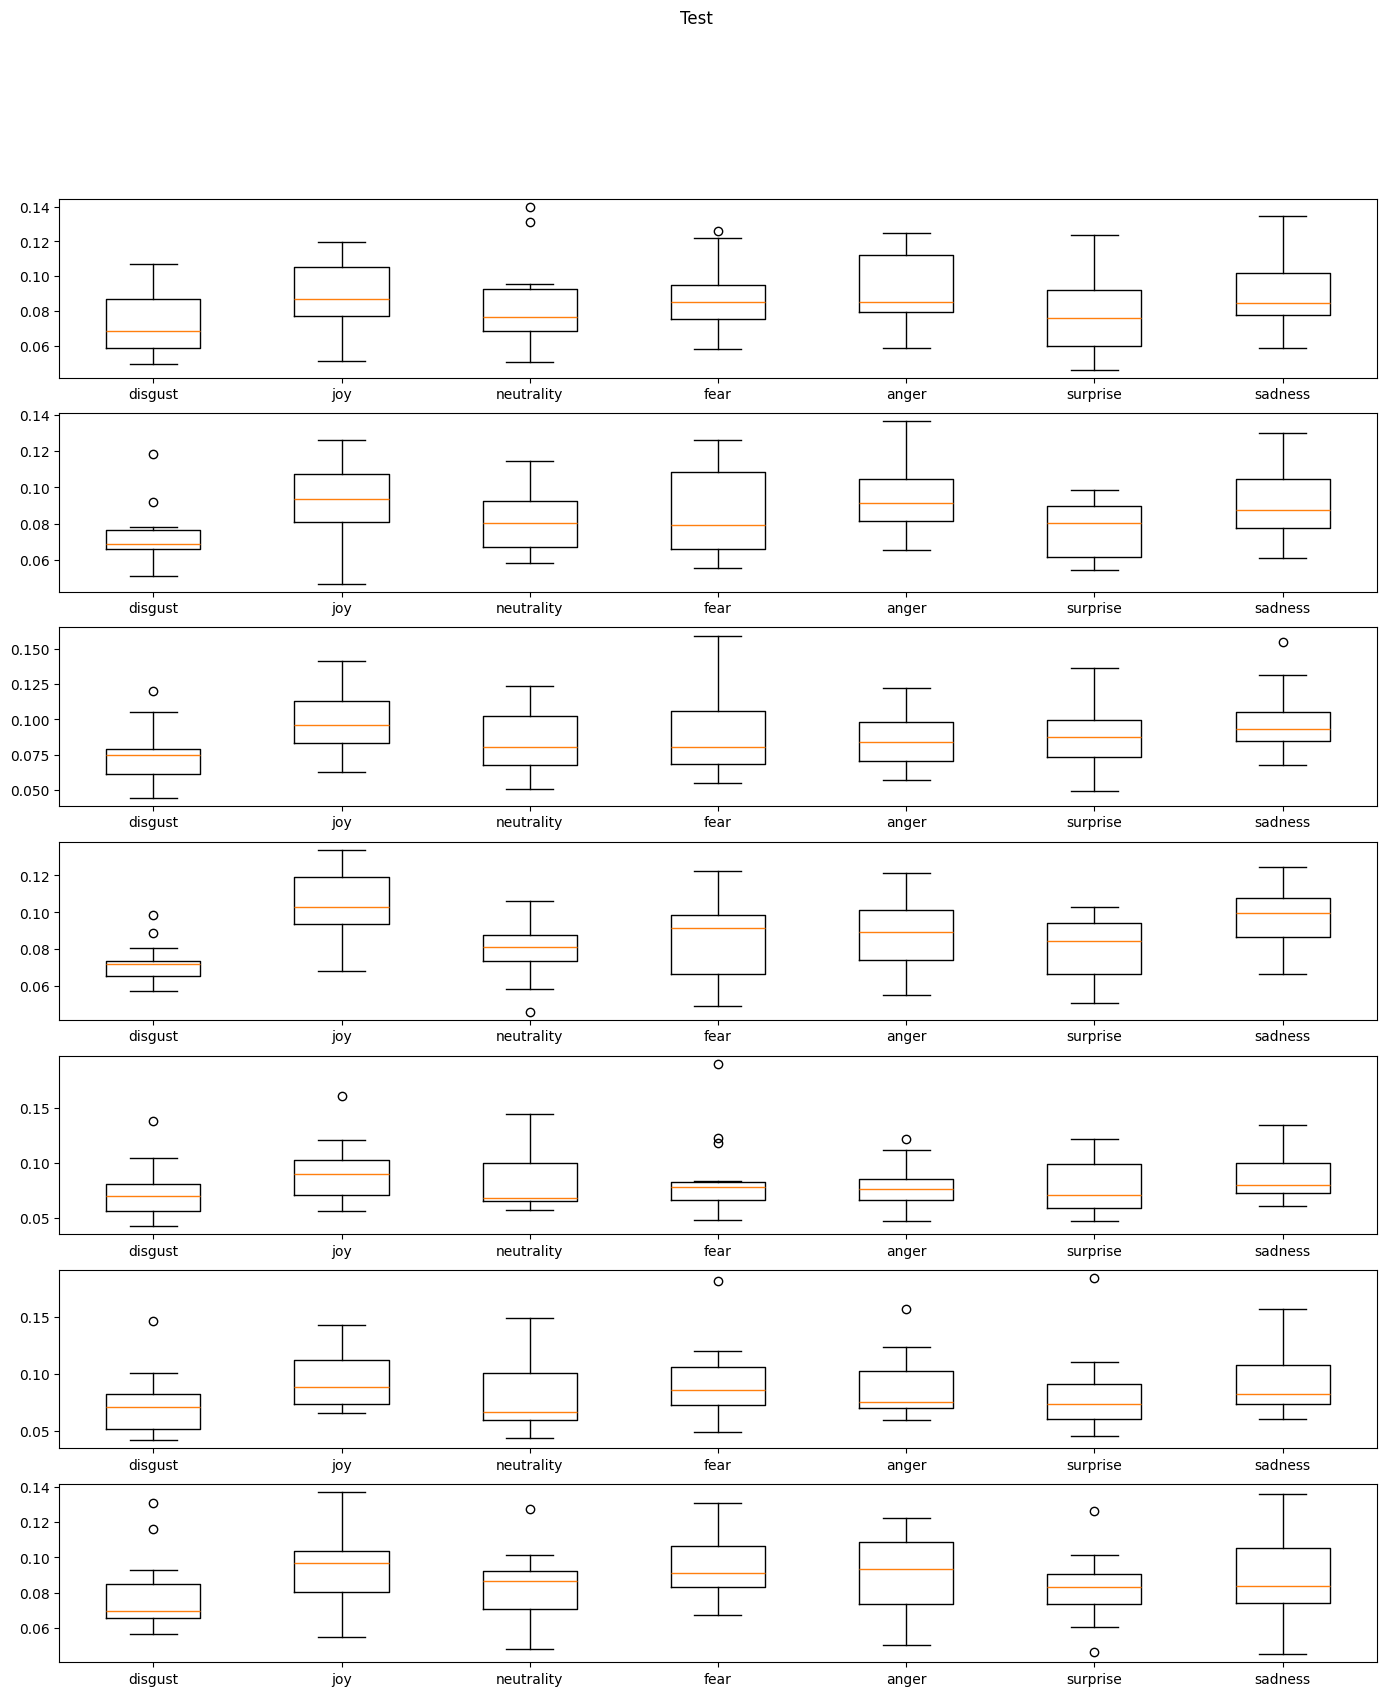

In [104]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 7
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(17,19))
# for x in range(n_rows):
for i in range(len(emo_test)):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)

    axes[i].boxplot([emo_test[i][:,0], emo_test[i][:,1],emo_test[i][:,2],emo_test[i][:,3],emo_test[i][:,4],emo_test[i][:,5],emo_test[i][:,6]], tick_labels=labels )
    # axes[i].set_title(f"{labels[i]}")
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Test")

plt.savefig("OvA_EMOVO_test.png")

In [ ]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 2
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17,7))
for x in range(n_rows):
    for i in range(4):
    # Crea i boxplot
        totale = np.concatenate((data_test[14:, :i], data_test[14:, i:]), axis=1)

        axes[x,i].boxplot([data_test[14:,i], np.mean(totale, axis=1)], tick_labels=[f"{labels[i]}", "Others"])
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Test")

plt.savefig("OvA_EMOVO_test.png")

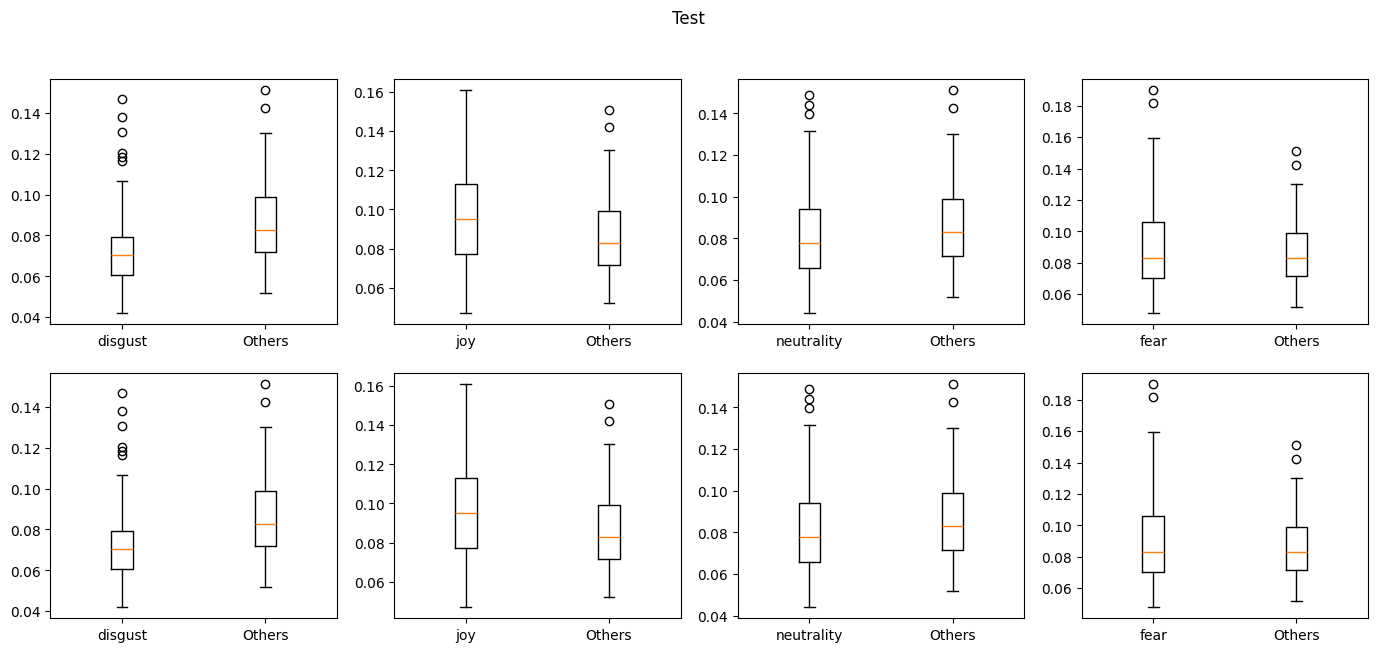

In [47]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 2
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17,7))
for x in range(n_rows):
    for i in range(4):
    # Crea i boxplot
        totale = np.concatenate((data_test[:, :i], data_test[:, i:]), axis=1)

        axes[x,i].boxplot([data_test[:,i], np.mean(totale, axis=1)], tick_labels=[f"{labels[i]}", "Others"])
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Test")

plt.savefig("OvA_EMOVO_test.png")

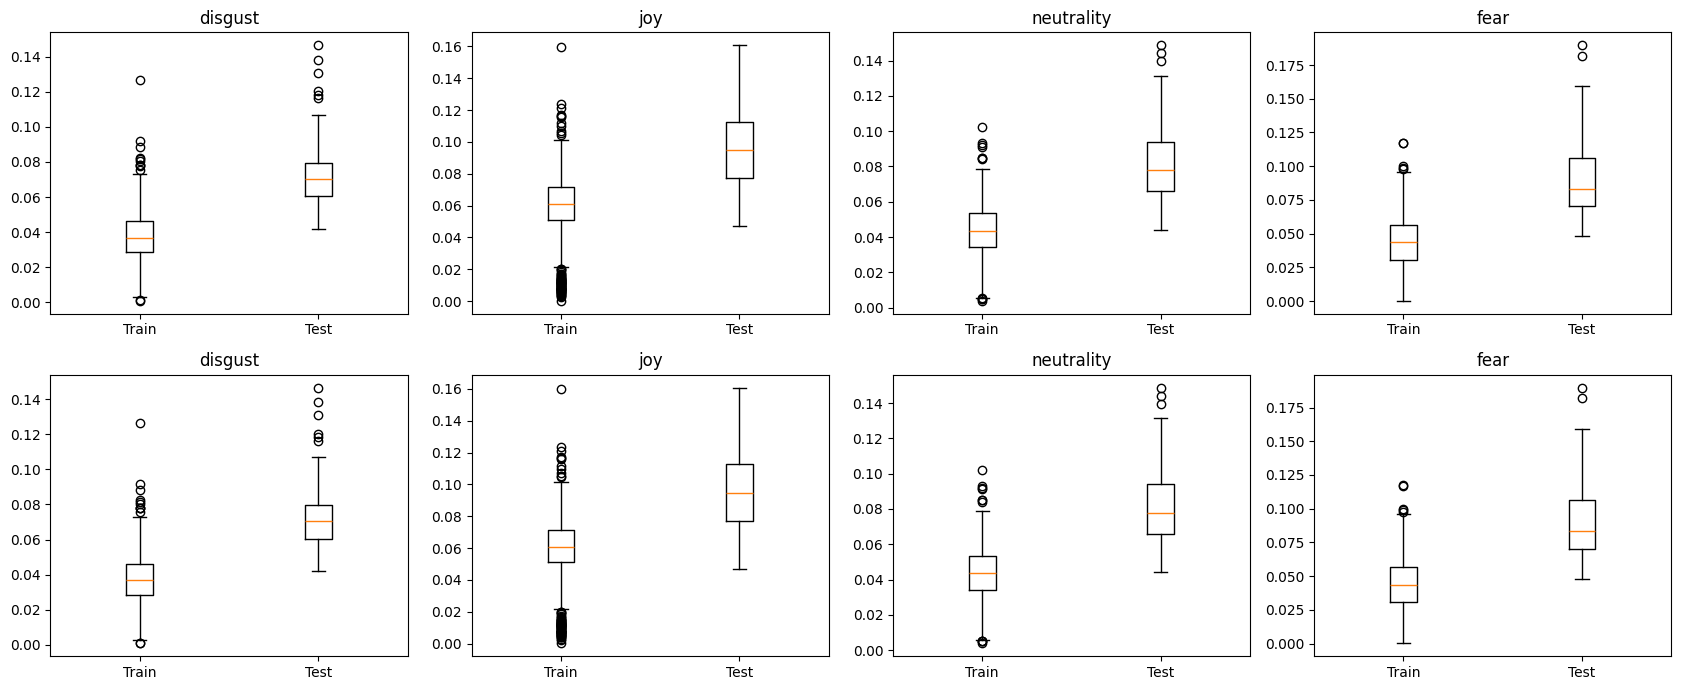

In [27]:
# fig, ax = plt.subplots()
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 2
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17,7))
for x in range(n_rows):
    for i in range(4):
    # Crea i boxplot
        axes[x,i].boxplot([data_train[:,i], data_test[:,i]], tick_labels=['Train', 'Test'])
        axes[x,i].set_title(f"{labels[i]}")



plt.tight_layout()
plt.savefig("Confronto_EMOVO.png")
# Personalizza il grafico (opzionale)
# plt.title('Confronto tra due set di dati')
# plt.ylabel('Reconstruction errro')

{'whiskers': [<matplotlib.lines.Line2D at 0x1ee246b2720>,
 'caps': [<matplotlib.lines.Line2D at 0x1ee246b11f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ee246b3200>],
 'medians': [<matplotlib.lines.Line2D at 0x1ee276c5dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ee276c66f0>],
 'means': []}

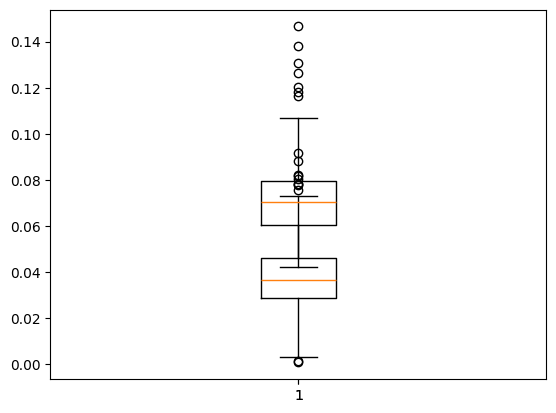

In [12]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)

plt.boxplot(data_train[:,0])
plt.boxplot(data_test[:,0])


# for i in range(7):
#     ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

Text(0, 0.5, 'Reconstruction error')

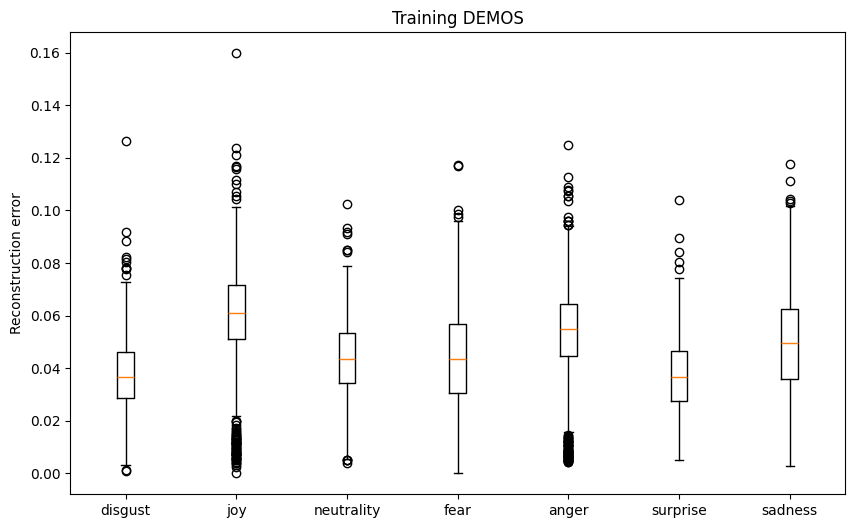

In [7]:
data =np.array(errro_train)
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(7):
    ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f"{labels[i]}" for i in range(7)])

# Set the title and labels
ax.set_title("Training DEMOS")
ax.set_ylabel("Reconstruction error")


# plt.show()
# plt.savefig("Boxplot_DEMOS_train.png")

Text(0, 0.5, 'Reconstruction error')

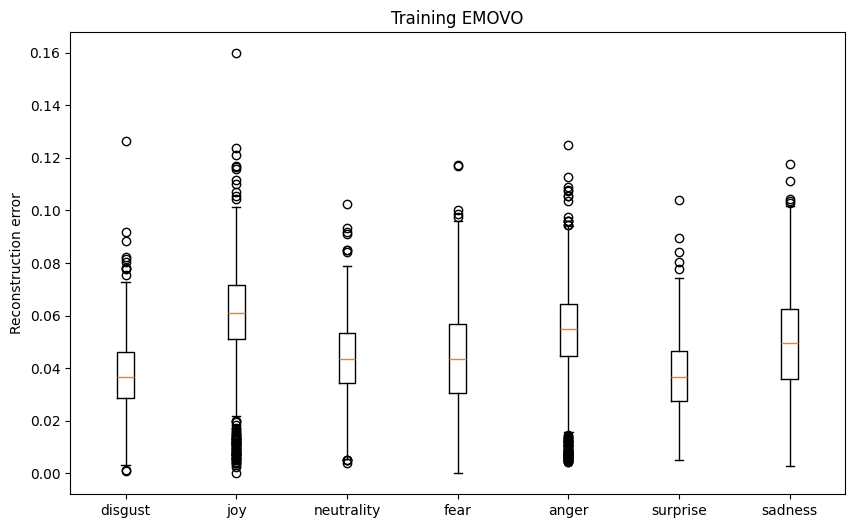

In [8]:
data =np.array(errro_train)
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(7):
    ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f"{labels[i]}" for i in range(7)])

# Set the title and labels
ax.set_title("Training EMOVO")
ax.set_ylabel("Reconstruction error")


# plt.show()
# plt.savefig("Boxplot_EMOVO_train.png")

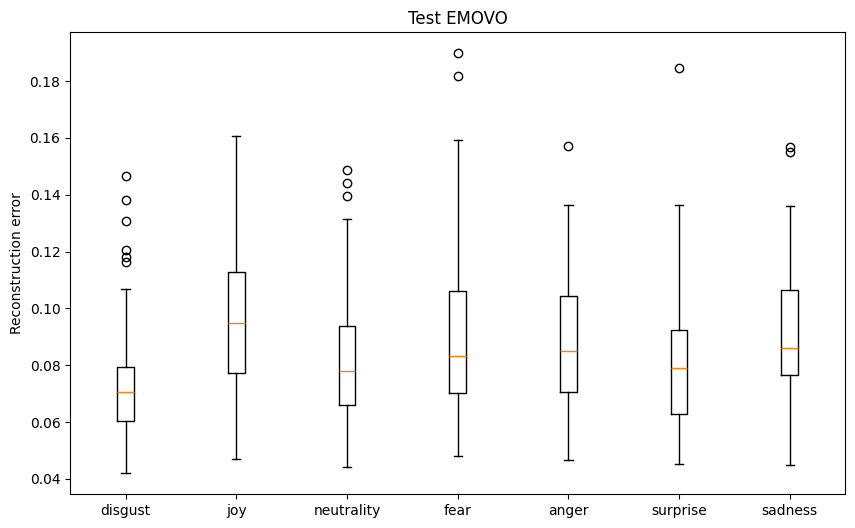

In [81]:
data =np.array(test_errors)
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(7):
    ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f"{labels[i]}" for i in range(7)])

# Set the title and labels
ax.set_title("Test EMOVO")
ax.set_ylabel("Reconstruction error")

# plt.show()
plt.savefig("Boxplot_EMOVO_test.png")

In [ ]:
import pickle
with open('errors_train_demos.pkl', 'wb') as handle:
    pickle.dump(errro_train, handle)



with open('errors_test_demos.pkl', 'wb') as handle:
    pickle.dump(errors, handle)

{'whiskers': [<matplotlib.lines.Line2D at 0x2400bdeff50>,
 'caps': [<matplotlib.lines.Line2D at 0x2400bd94560>,
 'boxes': [<matplotlib.lines.Line2D at 0x2400bdefcb0>],
 'medians': [<matplotlib.lines.Line2D at 0x2400bd94ad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2400bd94d70>],
 'means': []}

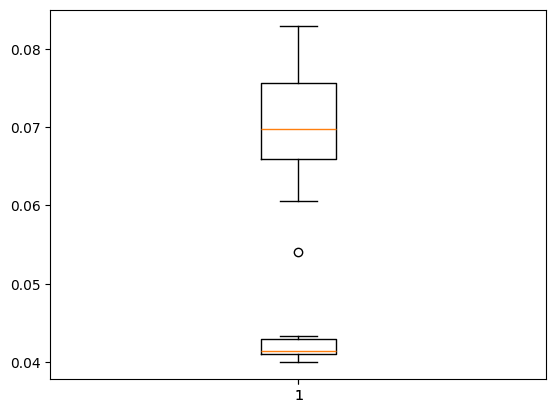

In [27]:
plt.boxplot(np.mean(errors, axis=0))
plt.boxplot(np.mean(errro_train, axis=0))

In [ ]:
predict su training - boxplot (2 boxplot uno train uno test - )

In [18]:
errors[:12]

[[0.09776781,
  0.14706425,
  0.11928873,
  0.09415389,
  0.11661363,
  0.12297818,
  0.08031848,
  0.10203273],
 [0.05326116,
  0.062158205,
  0.07045445,
  0.060693968,
  0.08329714,
  0.08979998,
  0.067464896,
  0.06583438],
 [0.04792208,
  0.06559345,
  0.075408265,
  0.06660958,
  0.09114426,
  0.08414332,
  0.079307675,
  0.061760448],
 [0.07286747,
  0.07093237,
  0.09779748,
  0.08671812,
  0.09551246,
  0.10390114,
  0.080414146,
  0.09003662],
 [0.06483802,
  0.08864486,
  0.097491264,
  0.07106492,
  0.10944128,
  0.0963198,
  0.07908068,
  0.072883025],
 [0.104773924,
  0.13794874,
  0.13338241,
  0.10221284,
  0.13701142,
  0.13418517,
  0.121240266,
  0.10875473],
 [0.10173703,
  0.12664205,
  0.120765574,
  0.10304007,
  0.13230932,
  0.12629849,
  0.117886655,
  0.12741715],
 [0.065119125,
  0.085141,
  0.08670609,
  0.08568755,
  0.10883519,
  0.10603907,
  0.08245248,
  0.08543436],
 [0.05053078,
  0.07791419,
  0.069114596,
  0.07476472,
  0.084046535,
  0.08424477,

In [13]:
y_true[:12], y_pred[:12], errors[:12]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [6, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0],
 [[0.09776781,
   0.14706425,
   0.11928873,
   0.09415389,
   0.11661363,
   0.12297818,
   0.08031848,
   0.10203273],
  [0.05326116,
   0.062158205,
   0.07045445,
   0.060693968,
   0.08329714,
   0.08979998,
   0.067464896,
   0.06583438],
  [0.04792208,
   0.06559345,
   0.075408265,
   0.06660958,
   0.09114426,
   0.08414332,
   0.079307675,
   0.061760448],
  [0.07286747,
   0.07093237,
   0.09779748,
   0.08671812,
   0.09551246,
   0.10390114,
   0.080414146,
   0.09003662],
  [0.06483802,
   0.08864486,
   0.097491264,
   0.07106492,
   0.10944128,
   0.0963198,
   0.07908068,
   0.072883025],
  [0.104773924,
   0.13794874,
   0.13338241,
   0.10221284,
   0.13701142,
   0.13418517,
   0.121240266,
   0.10875473],
  [0.10173703,
   0.12664205,
   0.120765574,
   0.10304007,
   0.13230932,
   0.12629849,
   0.117886655,
   0.12741715],
  [0.065119125,
   0.085141,
   0.08670609,
   0.08568755,
   0

Text(0.5, 1.0, 'Test on f_01')

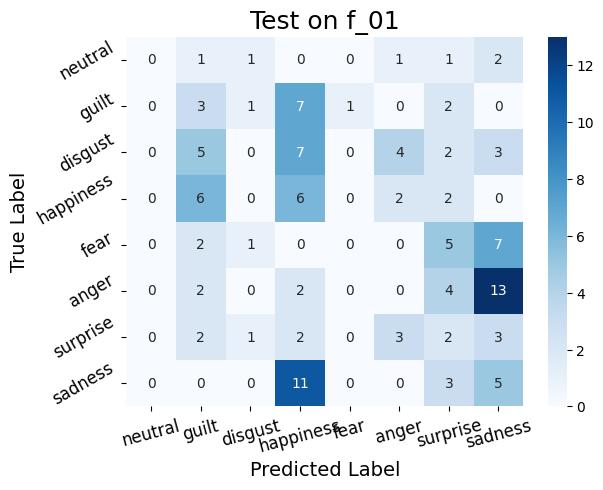

In [32]:
cm = confusion_matrix(y_true,y_pred)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
g.set_xlabel("Predicted Label", fontsize=14)
g.set_ylabel("True Label", fontsize = 14)
g.set_title("Test on f_01", fontsize = 18)

# plt.savefig("One_speaker_out_female.png")

In [15]:
# cm = confusion_matrix(y_true,y_pred)

# g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
# g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
# g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
# g.set_xlabel("Predicted Label", fontsize=14)
# g.set_ylabel("True Label", fontsize = 14)
# # g.set_title(data, fontsize = 18)

# plt.savefig("One_speaker_out_male.png")

In [33]:
from sklearn.metrics import average_precision_score
score = 1 - np.array(errors)
true_lab = y_true
ap = average_precision_score(true_lab, score, average="weighted")

ap

0.16202719588540307

In [107]:
from sklearn.metrics import average_precision_score, recall_score, precision_score
ap_scores = []
fpr_list = []
tpr_list = []
roc_auc_list = []
for i in range(len(errors)):
    score = 1- np.array(errors)
    print(len(score))
    true_lab = y_true
    ap = average_precision_score(true_lab, score)
    ap_scores.append(ap)
    fpr, tpr, _ = roc_curve(true_lab, score)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
print(f"AP Scores: {ap_scores}")
mAP = np.mean(ap_scores)

196


ValueError: multiclass format is not supported